# Qualitative analyses
In this notebook, I include all of my qualitative anlayses/results.

## Setup
To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [1]:
#Mounting Google Drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 804.1 MB 2.0 kB/s 
     |████████████████████████████████| 17.4 MB 118 kB/s 
     |████████████████████████████████| 7.1 MB 14.7 MB/s 
     |████████████████████████████████| 2.2 MB 23.7 MB/s 
     |████████████████████████████████| 17.4 MB 163 kB/s 
     |████████████████████████████████| 98 kB 6.1 MB/s 
     |████████████████████████████████| 15.3 MB 166 kB/s 
     |████████████████████████████████| 11.5 MB 12 kB/s 
     |████████████████████████████████| 806 kB 72.4 MB/s 
     |████████████████████████████████| 8.3 MB 17.3 MB/s 
     |████████████████████████████████| 27.4 MB 130 kB/s 
     |████████████████████████████████| 51.0 MB 51 kB/s 
     |████████████████████████████████| 165 kB 73.4 MB/s 
     |████████████████████████████████| 37.1 MB 43 kB/s 
     |████████████████████████████████| 10.6 MB 19.4 MB/s 
     |████████████████████████████████| 829 kB 56.1 MB/s 
     |████████████████████████████████| 234 kB 52.4 MB/s 
     |███████████

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
ASPDNET_HYPERPARAMETERS = config['ASPDNet_params']
FASTER_RCNN_HYPERPARAMETERS = config['faster_rcnn_params']
tile_size = tuple(config['tile_size'])

In [2]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'density_estimation'))
sys.path.append(os.path.join(CODE_FP, 'object_detection'))
sys.path.append(os.path.join(CODE_FP, 'density_estimation', 'ASPDNet'))

from bird_dataset import *
from ASPDNet_model import *
from ASPDNet.model import ASPDNet
from faster_rcnn_model import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything
import torchvision.transforms as transforms
from matplotlib import cm as CM

## General stuff

In [3]:
#Setting our random seed for all operations (PyTorch, numpy, python.random)
seed_everything(SEED)

#Establishing the datasets/dataloaders
bird_dataset_eval_aspdnet = BirdDataset(root_dir = DATA_FP, 
                                        transforms = get_transforms('density_estimation', train = False), 
                                        tiling_method = 'w_o_overlap', 
                                        annotation_mode = 'points', 
                                        tile_size = tile_size,
                                        sigma = 3)
bird_dataset_eval_frcnn = BirdDataset(root_dir = DATA_FP, 
                                      transforms = get_transforms('object_detection', train = False), 
                                      tiling_method = 'w_o_overlap', 
                                      annotation_mode = 'bboxes',
                                      tile_size = tile_size) 

#  recovering the test set
indices = torch.randperm(len(bird_dataset_eval_aspdnet)).tolist() #TODO: switch w/the custom permutation once you have the dataset all in order!
print(f'Indices used: {indices[28 : ]}')
dataset_test_aspdnet = torch.utils.data.Subset(bird_dataset_eval_aspdnet, indices[28 : ])
dataset_test_frcnn = torch.utils.data.Subset(bird_dataset_eval_frcnn, indices[28 : ]) 

#  wrapping datasets in dataloaders
dataloader_test_aspdnet = DataLoader(dataset_test_aspdnet, batch_size = ASPDNET_HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_density) 
dataloader_test_frcnn = DataLoader(dataset_test_frcnn, batch_size = FASTER_RCNN_HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_object_detection) 

Global seed set to 1693


Indices used: [29, 13, 26, 31, 8, 4]


In [4]:
#Loading both models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  ASPDNet...
save_name = 'ASPDNet_no_neg_densities_200_epochs_7.7.2021.ckpt'
aspdnet = ASPDNet(allow_neg_densities = False).to(device)
pl_model_aspdnet = ASPDNetLightning.load_from_checkpoint(os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name), model = aspdnet)
pl_model_aspdnet.model.eval()

#  Faster R-CNN... TODO: uncomment eventually!
save_name = 'model1_6.23.2021.pth'
frcnn = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2, **FASTER_RCNN_HYPERPARAMETERS['constructor_hyperparams']).to(device) 
frcnn.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', '40_epoch_runs', save_name)))
pl_model_frcnn = FasterRCNNLightning(model = frcnn)
pl_model_frcnn.model.eval();

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Best/worst tiles
Seeing where each model struggles the most and least.

### _Faster R-CNN_

In [ ]:
#Saving the worst/best tiles as we go for Faster R-CNN (non-neg tiles use percent error, neg tiles use absolute error)
best_pe = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'PE' : np.inf}
worst_pe = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'PE' : np.NINF}
best_ae = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'AE' : np.inf}
worst_ae = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'AE' : np.NINF}

with torch.no_grad(): #we aren't performing updates, so no grad calculations are necessary... also helps avoid CUDA OOM errors!
  for tiles, targets, _, _ in dataloader_test_frcnn:
    tiles = [t.to(device) for t in tiles]

    preds = pl_model_frcnn(tiles)
    true_bboxes = [t['boxes'] for t in targets]

    for tile, pred_dict, gt in zip(tiles, preds, true_bboxes):
      pred_boxes = pred_dict['boxes']
      
      gt_count = len(gt)
      pred_count = len(pred_boxes)

      if gt_count != 0: #case where not a neg example tile (zero birds)
        pe = 100 * np.absolute(pred_count - gt_count) / gt_count

        if pe < best_pe['PE']:
          best_pe = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'PE' : pe}
        elif pe > worst_pe['PE']:
          worst_pe = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'PE' : pe}
      elif gt_count == 0:
        ae = np.absolute(pred_count - gt_count)

        if ae < best_ae['AE']:
          best_ae = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'AE' : ae}
        elif ae > worst_ae['AE']:
          worst_ae = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'AE' : ae}

In [ ]:
#Function to handle visualization for bboxes
def visualize_pred_v_gt_BBOXES(error_dict):
  img = (np.moveaxis(error_dict['img'].cpu().numpy(), 0, -1) * 255).astype(np.uint8)
  gt_boxes = error_dict['gt_bboxes'].tolist()
  pred_boxes = error_dict['pred_bboxes'].tolist()

  pil_img_pred = Image.fromarray(np.copy(img).astype(np.uint8))
  draw = ImageDraw.Draw(pil_img_pred)
  for b in pred_boxes:
      draw.rectangle(b, outline = 'red', width = 1)

  pil_img_gt = Image.fromarray(np.copy(img).astype(np.uint8))
  draw = ImageDraw.Draw(pil_img_gt)
  for b in gt_boxes:
      draw.rectangle(b, outline = 'green', width = 1)

  return pil_img_pred, pil_img_gt

True count is 1, predicted count is 19, PE is 1800.0%


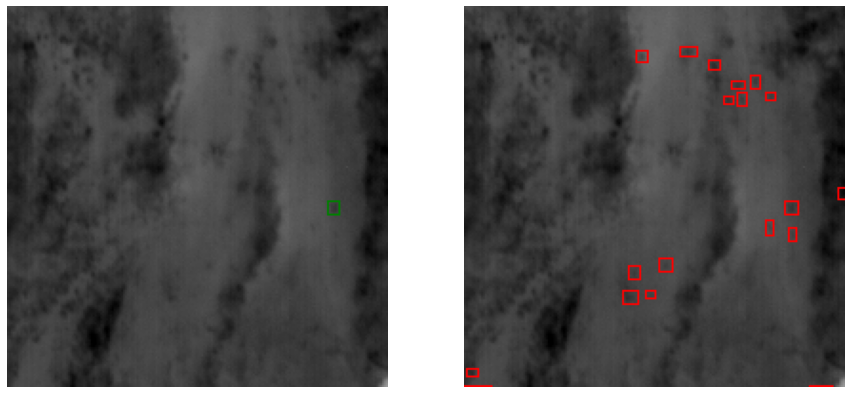

In [ ]:
#Visualizing percent error tiles...
error_dict = worst_pe #either "best_pe" or "worst_pe" here!
pil_img_pred, pil_img_gt = visualize_pred_v_gt_BBOXES(error_dict)
print(f'True count is {len(error_dict["gt_bboxes"])}, predicted count is {len(error_dict["pred_bboxes"])}, PE is {error_dict["PE"]}%')

f, axarr = plt.subplots(1, 2, figsize = (15, 10))
axarr[0].imshow(pil_img_gt)
axarr[1].imshow(pil_img_pred)
for a in axarr:
    a.axis('off')

True count is 0, predicted count is 35, AE is 35


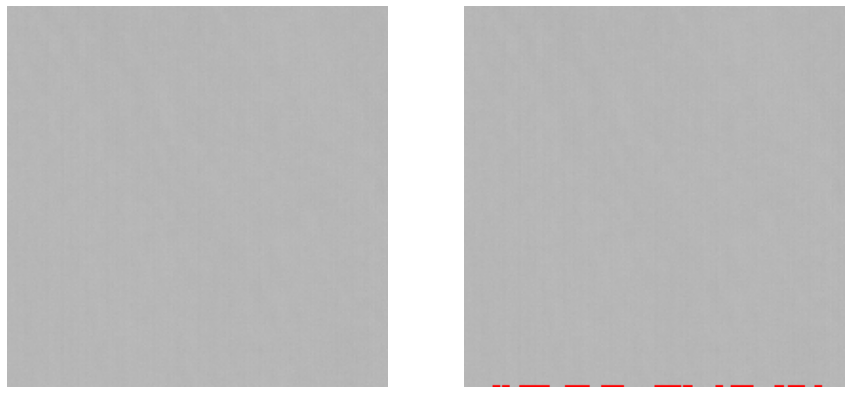

In [ ]:
#Visualizing absolute error tiles...
error_dict = worst_ae #either "best_ae" or "worst_ae" here!
pil_img_pred, pil_img_gt = visualize_pred_v_gt(error_dict)
print(f'True count is {len(error_dict["gt_bboxes"])}, predicted count is {len(error_dict["pred_bboxes"])}, AE is {error_dict["AE"]}')

f, axarr = plt.subplots(1, 2, figsize = (15, 10))
axarr[0].imshow(pil_img_gt)
axarr[1].imshow(pil_img_pred)
for a in axarr:
    a.axis('off')

### _ASPDNet_

In [ ]:
#Saving the worst/best tiles as we go for ASPDNet (non-neg tiles use percent error, neg tiles use absolute error)
best_pe = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'PE' : np.inf}
worst_pe = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'PE' : np.NINF}
best_ae = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'AE' : np.inf}
worst_ae = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'AE' : np.NINF}

with torch.no_grad():
  for tiles, gt_densities, counts in dataloader_test_aspdnet:
    tiles = tiles.to(device)

    preds = pl_model_aspdnet(tiles)

    for tile, pred_den, gt_den, gt_count in zip(tiles, list(preds), list(gt_densities), counts):
      pred_count = float(pred_den.sum())

      if gt_count != 0: #case where not a neg example tile (zero birds)
        pe = 100 * np.absolute(pred_count - gt_count) / gt_count

        if pe < best_pe['PE']:
          best_pe = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'PE' : pe}
        elif pe > worst_pe['PE']:
          worst_pe = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'PE' : pe}
      elif gt_count == 0:
        ae = np.absolute(pred_count - gt_count)

        if ae < best_ae['AE']:
          best_ae = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'AE' : ae}
        elif ae > worst_ae['AE']:
          worst_ae = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'AE' : ae}

In [ ]:
#Function to handle visualization for bboxes
def visualize_pred_v_gt_DENSITIES(error_dict):
  invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0.],
                                                      std = [ 1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406],
                                                      std = [ 1., 1., 1.]),
                                ])
  
  img = invTrans(error_dict['img'])
  img = (np.moveaxis(img.cpu().numpy(), 0, -1) * 255).astype(np.uint8)
  pred_den = error_dict['pred_den'].cpu().squeeze(0)
  gt_den = error_dict['gt_den']

  return img, pred_den, gt_den

True count is 1, predicted count is 4.066141605377197, PE is 306.6141605377197%


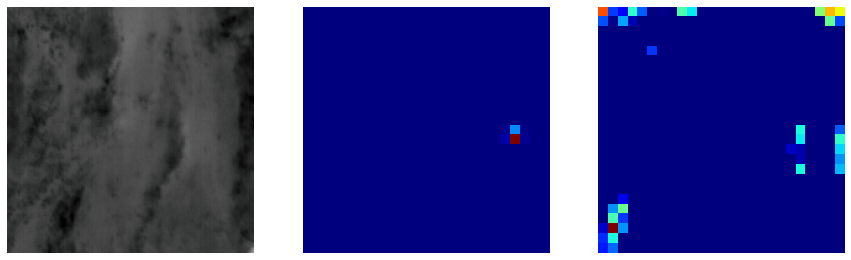

In [ ]:
#Visualizing the percent error tiles...
error_dict = worst_pe
img, pred_den, gt_den = visualize_pred_v_gt_DENSITIES(error_dict)
print(f'True count is {error_dict["gt_count"]}, predicted count is {float(error_dict["pred_den"].sum())}, PE is {error_dict["PE"]}%')

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(img)
axarr[1].imshow(gt_den, cmap = CM.jet)
axarr[2].imshow(pred_den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

True count is 0, predicted count is 18.488842010498047, AE is 18.488842010498047


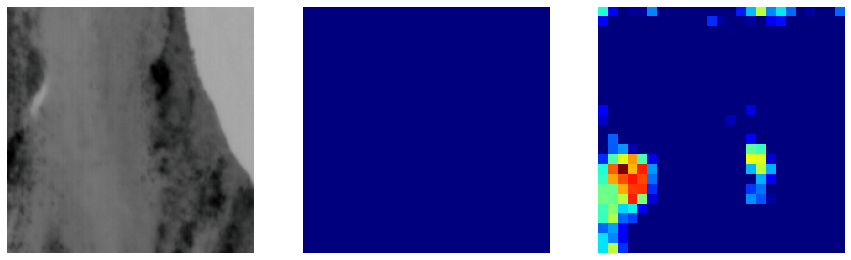

In [ ]:
#Visualizing the absolute error tiles...
error_dict = worst_ae
img, pred_den, gt_den = visualize_pred_v_gt_DENSITIES(error_dict)
print(f'True count is {error_dict["gt_count"]}, predicted count is {float(error_dict["pred_den"].sum())}, AE is {error_dict["AE"]}')

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(img)
axarr[1].imshow(gt_den, cmap = CM.jet)
axarr[2].imshow(pred_den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

## Testing out on particular tiles

**TODO:** Pull out a few specific parent images that seem like they would be difficult (flying birds, birds on land, ambiguous birds) and see how the models do by predicting and visualizing.

-----

**Ideas:**
- `7162` (index 0) and `7105` (index 1) have some birds on land, although they're easier bird on land examples
  - in `7162`: tiles 18 and 25
- `2806` (index 5) has some super dense, pretty small signatures
- **TODO:** add more once you add in the supplemental imagery

### *Tiles w/birds on land*

In [16]:
#WE CAN GRAB TILES LIKE THIS, THEN PREDICT ON THEM, THEN VISAULIZE!
im_7162 = dataset_test_frcnn[0]

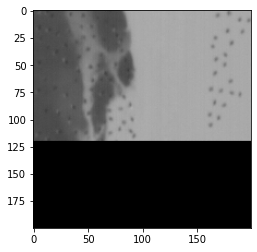

In [25]:
img = (np.moveaxis(im_7162[25][0].numpy(), 0, -1) * 255).astype(np.uint8)
plt.imshow(img)

### *Tiles w/dense birds*

### *Tiles w/birds in flight*

### *Tiles w/difficult 2018 signatures*